<a href="https://colab.research.google.com/github/BillyTevin11/Coding-Projects/blob/main/Valencia_Flooding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Required Libraries

In [1]:
import ee
import geemap
import geemap.colormaps as cm

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-vindevon11')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


# Study Area

In [3]:
valencia = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Spain')) \
    .filter(ee.Filter.eq('ADM1_NAME', 'Comunitat Valenciana'))

valencia = valencia.geometry()

Map = geemap.Map(height=600)
Map.centerObject(valencia, 8)

Map.addLayer(valencia, {}, 'Comunitat Valenciana')


# Precipitation Analysis in Comunitat Valenciana, Espana

In [4]:
dataset = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filter(ee.Filter.date('2024-01-01', '2024-09-30'))

In [5]:
precipitation = dataset.select('precipitation')

In [6]:
# Calculate the mean monthly precipitation for 2024
monthly_precipitation = precipitation.mean().reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': valencia,
    'scale': 5000,
    'maxPixels': 1e13
}).get('precipitation')

In [7]:
# Get the months (1-12)
months = ee.List.sequence(1, 9)

In [8]:
# Function to calculate the mean precipitation for a specific month
def calculate_monthly_mean(month):
  monthly_image = precipitation.filter(ee.Filter.calendarRange(month, month, 'month')) \
      .mean() \
      .reduceRegion(**{
          'reducer': ee.Reducer.mean(),
          'geometry': valencia,
          'scale': 5000,
          'maxPixels': 1e13
      })
  return monthly_image.get('precipitation')

In [9]:
monthly_means = months.map(calculate_monthly_mean)

# Convert the mean precipitation list to a client-side list
monthly_means_list = monthly_means.getInfo()

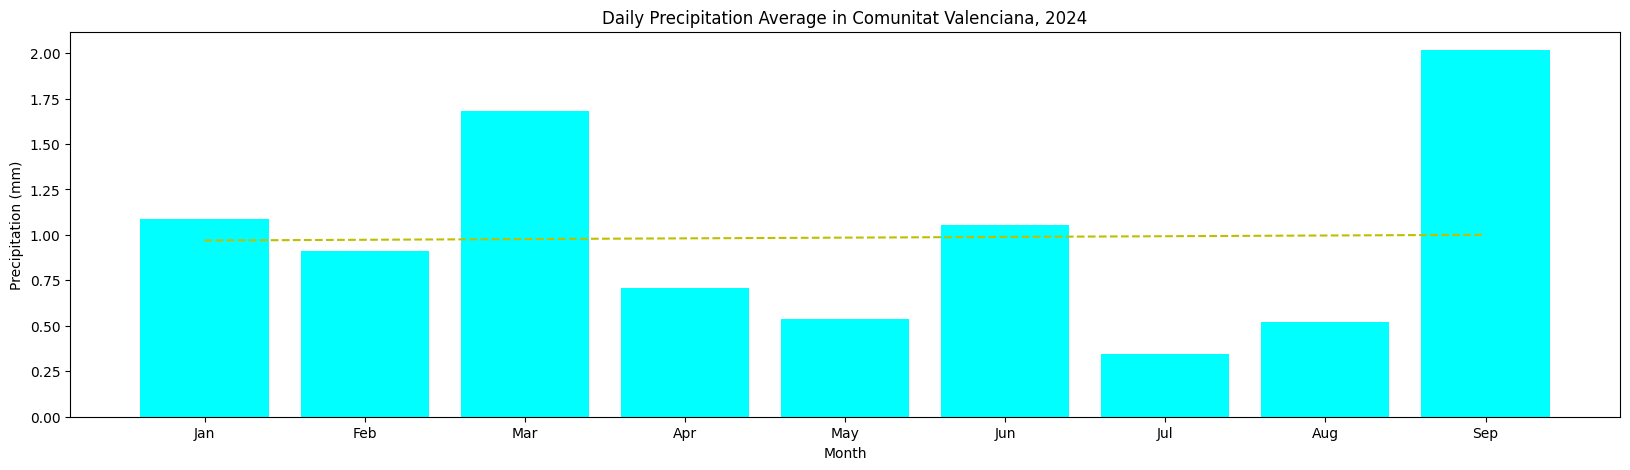

In [10]:
# Create a list of month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Create a chart
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(month_labels, monthly_means_list, color='aqua')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation Average in Comunitat Valenciana, 2024')

import numpy as np
# Add trend line
z = np.polyfit(range(len(monthly_means_list)), monthly_means_list, 1)
p = np.poly1d(z)
plt.plot(month_labels, p(range(len(monthly_means_list))), "y--")

# Show the chart
plt.show()

# Radar Visualization

In [11]:
before_radar = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(valencia) \
    .filterDate('2024-10-01', '2024-10-08') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .select('VH') \
    .median() \
    .clip(valencia)

In [12]:
after_radar = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(valencia) \
    .filterDate('2024-10-21', '2024-11-01') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .select('VH') \
    .median() \
    .clip(valencia)

In [13]:
# Define visualization parameters
vis_params = {
    'min': -25,
    'max': 0,
    'palette': ['black', 'white']
}

palette = cm.palettes.Blues_r

flood_vis = {
    'min': -25,
    'max': 0,
    'palette': palette
}

In [14]:
flood_sar = after_radar.subtract(before_radar)

In [15]:
Map.addLayer(before_radar, vis_params, 'SAR - Before', False)
Map.addLayer(after_radar, vis_params, 'SAR - After', False)
Map.addLayer(flood_sar, flood_vis, 'Flood - SAR')
Map

Map(center=[39.393696314291645, -0.5572041619803199], controls=(WidgetControl(options=['position', 'transparen…

# Optical Visualization

In [16]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [17]:
sen2_before = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2024-10-01', '2024-10-08')
    .filterBounds(valencia)
    .mosaic()
)

In [18]:
sen2_after = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2024-10-29', '2024-11-01')
    .filterBounds(valencia)
    .mosaic()
)

In [19]:
Map.addLayer(sen2_before, {'bands': ['B8', 'B4', 'B3']}, 'Sentinel-2 Before', False)

Map.addLayer(sen2_after, {'bands': ['B8', 'B4', 'B3']}, 'Sentinel-2 After', False)

Map

Map(bottom=100170.0, center=[39.33640517524938, -0.31155656512188884], controls=(WidgetControl(options=['posit…